# Optimized pupil phase mask for nodal region in focal plane

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
sys.path.append("../core/")
from pupil_masks import *
from optim_functions import *
import os
from skimage.transform import resize
from matplotlib.colors import LogNorm 



In [2]:
%matplotlib notebook

(4096, 4096)
204


../core/pupil_masks.py:167: RuntimeWarning: overflow encountered in power
  Pupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**500))*spider1*spider2


<IPython.core.display.Javascript object>


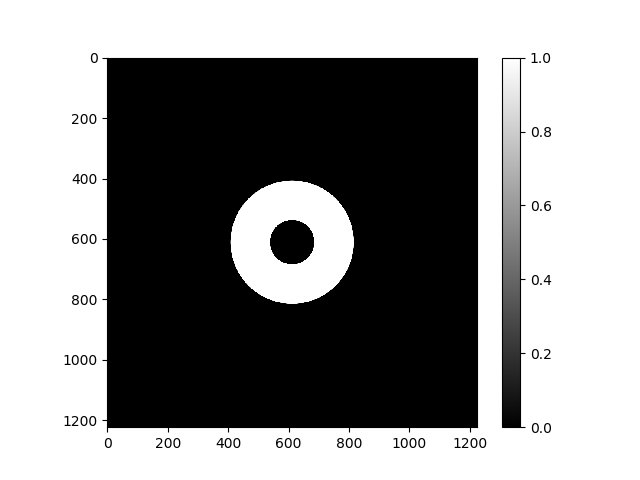

In [3]:
N = 4096
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)
print(X.shape)
RHO, THETA = cart2pol(X,Y) 

lambdaOverD = 10
apRad = int(N/(2*lambdaOverD))
print(int(apRad))


EP = make_Palomar_pupil(1024, apRad)
EP = np.lib.pad(EP, (1536, 1536), 'constant', constant_values=(0,0))

plot_im_LP(EP, apRad, 2)

## Vortex coronagraph

<IPython.core.display.Javascript object>


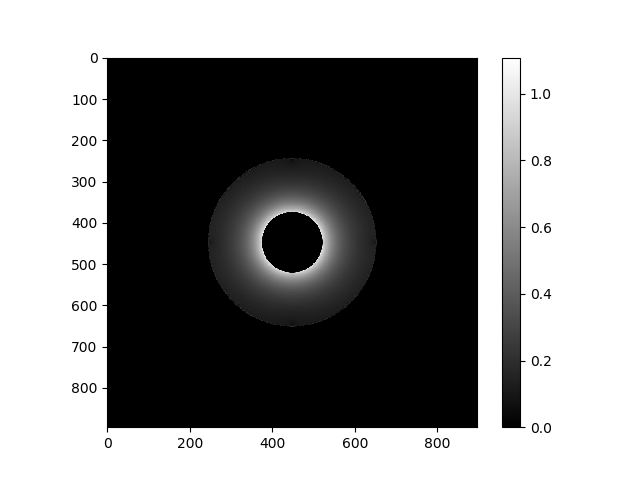

In [14]:
R0 = 0.015

FP = myfft2(EP)
FP_2 = ((1-R0)*np.exp(1j*2*THETA)*FP+R0*FP)
LP = myifft2(FP_2)
plot_im_LP(abs(LP)*EP, apRad, 1.2)

<IPython.core.display.Javascript object>


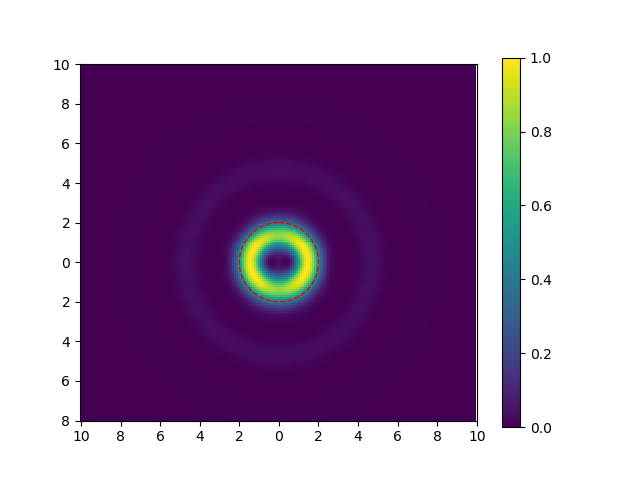

In [16]:
DI = np.abs(myfft2(LP*EP))**2
plot_im_ld(DI/np.max(DI), 10, 10)

## Circular nodal area from 1.5 to 2.5 lD

<IPython.core.display.Javascript object>


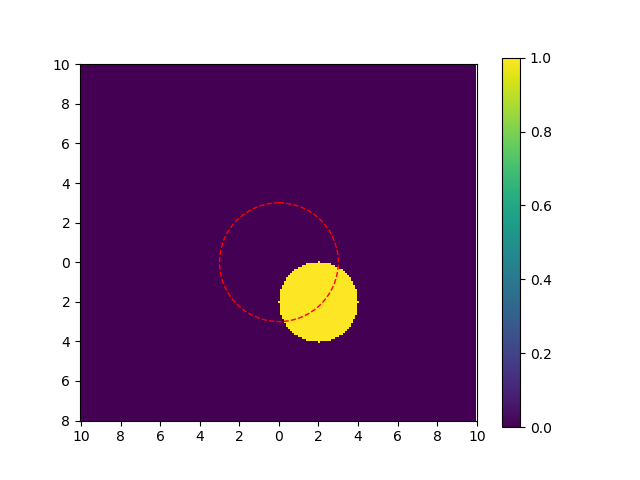

In [4]:
a = 2048 + 2*lambdaOverD

r = 2*lambdaOverD

y,x = np.ogrid[-a:N-a, -a:N-a]
mask = x*x + y*y <= r*r



OPT_REG_FP = np.zeros((N,N))
OPT_REG_FP[mask] =1
#OPT_REG_FP[np.where(RHO+3*<3*lambdaOverD)] = 1
#OPT_REG_FP[np.where(RHO<1.4*lambdaOverD)] = 0
#OPT_REG_FP[np.where(Y<0)] = 0
#OPT_REG_FP[np.where((Y<-20) & (Y>-35) & (X>20) & (X<35))] = 1
#OPT_REG_FP[np.where((Y<-20) & (Y>-35) & (X<-20) & (X>-35))] = 1
plot_im_ld(OPT_REG_FP, lambdaOverD, 10, n=3)

100%|██████████| 100/100 [01:50<00:00,  1.10s/it]


<IPython.core.display.Javascript object>


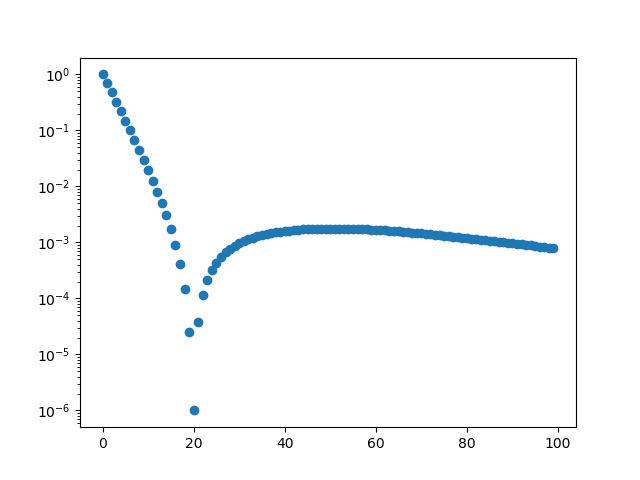

/Users/polychronispatapis/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
EPinit = np.ones((N,N))
optEP= modified_GS_amplitude(EP, EPinit, OPT_REG_FP, 100)



<IPython.core.display.Javascript object>


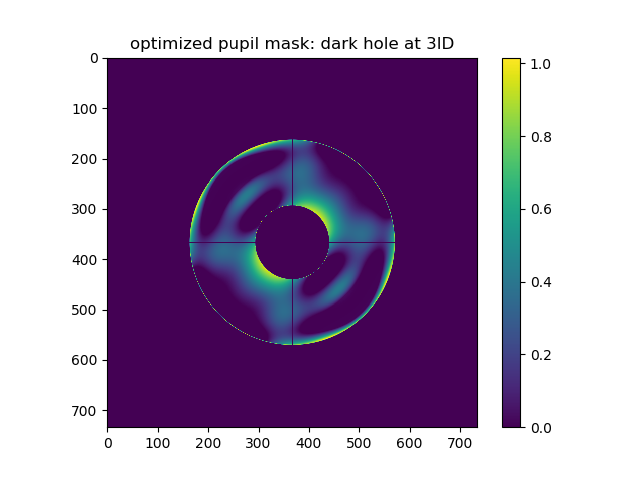

Text(0.5, 1.0, 'optimized pupil mask: dark hole at 3lD')

In [8]:
optPupil = EP*np.abs(optEP)
#optPupil[np.where(EP==0)] = np.nan
plot_im_LP(optPupil, apRad, 0.8, color='viridis')
plt.title("optimized pupil mask: dark hole at 3lD")

In [24]:
#save mask

hdu = fits.PrimaryHDU(data=np.angle(optEP))
hdu.header["PUPIL"] = "VLT"
hdu.header["lD"] = "10"
hdu.header["iter"] = "800"
hdu.header["OPTREG"]= "Dark hole at 3lD with a 2FWHM diameter"
hdu.header["DATE"] = "19/09/17"
hdu.writeto("/Users/patapisp/Documents/DAC/Optimized_pupil_phase_apodizer/Apodizer_dark_hole-3lD_VLT_800iter.fits")

## visualize results

<IPython.core.display.Javascript object>


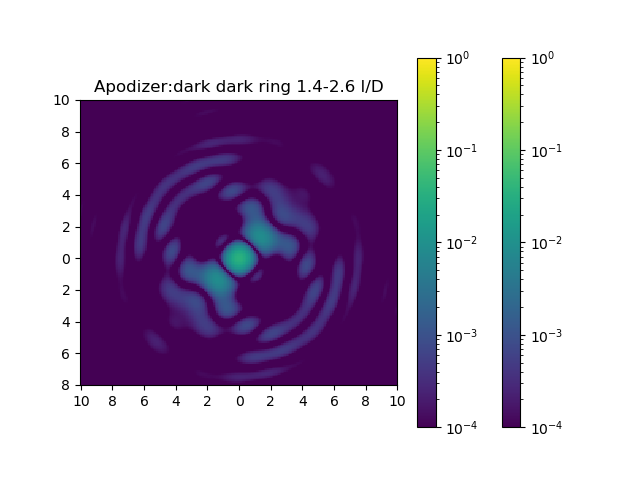

In [10]:
#optEP = fits.getdata("/Users/patapisp/Documents/DAC/Optimized_pupil_phase_apodizer/Apodizer_ring-1.4-2.6lD_VLT_400iter.fits")
#optEP = np.exp(1j*optEP)
PSF = np.abs(myfft2(EP))**2
PSFopt = np.abs(myfft2(EP*optEP))**2/np.max(PSF)
plot_im_ld(PSF/np.max(PSF), 10,10, n=None, log_scale=True, log_min=-4 )


In [11]:
plot_im_ld(PSFopt, 10, 10, n=None, log_scale=True, log_min=-4 )
plt.title("Apodizer:dark dark ring 1.4-2.6 l/D")
print(np.max(PSFopt))

0.03608117511212594


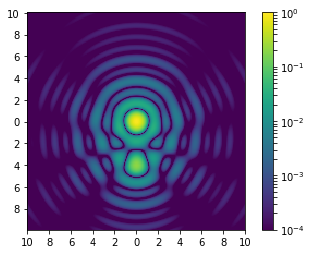

In [45]:
PSF = np.abs(myfft2(EP))**2
EP2 = EP*np.exp(1j*0.06*Y)
EPP = 0.5*EP2+EP
plot_im_ld(np.abs(myfft2(EPP))**2/np.max(PSF), 10, 10, n=None, log_scale=True, log_min=-4 )

0.654211306171


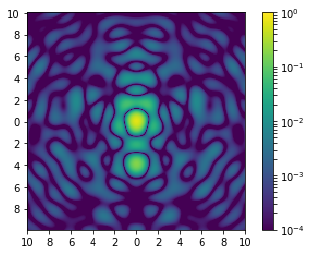

In [46]:
PSFopt = np.abs(myfft2(EPP*optEP))**2/np.max(PSF)
plot_im_ld(PSFopt, 10, 10, log_scale=True, n=None, log_min=-4 )
print(np.max(PSFopt))

/Users/patapisp/polybox/MasterProject/code/pupil_masks.py:45: RuntimeWarning: overflow encountered in power
  pupil = np.exp(-np.sqrt((X/a)**2 + (Y/b)**2)**1000)


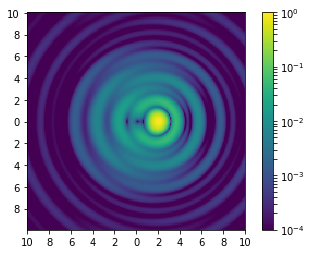

In [21]:
LS = make_elliptical_pupil(1024,1, apRad)
LS = np.lib.pad(LS, (1536, 1536), 'constant', constant_values=(0,0))
LP = myifft2(myfft2(EPP)*np.exp(1j*2*THETA))
LPopt = myifft2(myfft2(EPP*optEP)*np.exp(1j*2*THETA))
PSF = np.abs(myfft2(LP*LS))**2
PSFopt = np.abs(myfft2(LPopt*LS))**2
plot_im_ld(PSF/np.max(PSF), 10, 10, n=None, log_scale=True, log_min=-4 )

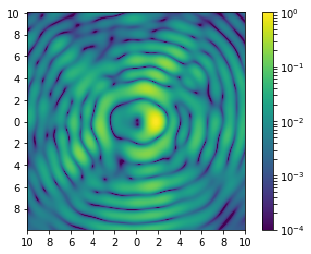

In [23]:
plot_im_ld(PSFopt/np.max(PSFopt), 10, 10, n=None, log_scale=True, log_min=-4 )

In [3]:
m = fits.getdata("/Users/patapisp/Documents/DAC/ZIMPOL_Mask/data_simulations/ZIMPOL_PSF_STREHL=40-100_optimized.fits")[-1]

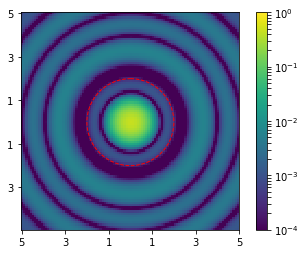

In [7]:
PSF = np.abs(myfft2(EP))**2
plot_im_ld(m/np.max(PSF), 10, 5, log_scale=True, log_min=-4)